# Figure SX - Constructs

In [162]:
# load external dependencies
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation
import brewer2mpl
from scipy import stats

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

# load internal dependencies
import colors,plot,stats,utils

%load_ext autoreload
%autoreload 2

# absolute file path for data directory
from config import *
from paths import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/pheno_populations_norm.pickle')

# normalise by the ancestral population
pheno_df['growth_rate'] = pheno_df['growth_rate'] - pheno_df[pheno_df.background=='ancestral'].growth_rate.mean()

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.background == 'parents')|\
                    (pheno_df.background == 'constructs')|\
                    ((pheno_df.background == 'evolved')&(pheno_df.population == 'WAxNA')&\
                     (pheno_df.cross == 'F12')&(pheno_df.cross_rep == 2)&\
                     (pheno_df.env_evo == 'HU')&(pheno_df.prop_rep == 2)&\
                     (pheno_df.isolate == 2)&(pheno_df.genotype_long == 'rnr2*/RNR2'))|\
                    ((pheno_df.background == 'evolved')&(pheno_df.population == 'WAxNA')&\
                     (pheno_df.cross == 'F12')&(pheno_df.cross_rep == 2)&\
                     (pheno_df.env_evo == 'RM')&(pheno_df.prop_rep == 2)&\
                     (pheno_df.isolate == 6)&(pheno_df.genotype_long == 'tor1*/TOR1'))]

pheno_df = pheno_df.replace('WAxNA','WA/NA')

# pheno_df['genotype'] = pheno_df['genotype'].map(lambda x: x.encode('utf-8'))

# duplicate shared controls by candidate gene
groups_1 = pheno_df.groupby(['env_evo','env_test','gene','population'])
for (ii,((env_evo, env_test, gene, population),g1)) in enumerate(groups_1):
    
    if gene!='':
        df = groups_1.get_group((env_evo, env_test,'', population))        
        df = df.replace([env_evo, env_test,'', population],[env_evo, env_test,gene, population])
        
        pheno_df = pheno_df.append(df)

pheno_df = pheno_df[pheno_df.gene != '']

pheno_df.head()  # show dataframe header to stdout

,env_evo,env_test,run,Index,Plate,Row,Column,ID,ID_plate,background,...,assignment,isolate,gene,genotype_short,genotype_long,aminoacid,mating,auxotrophy,doubling_time,growth_rate
466,RM,RM,1,466,0,9,34,P10_C9,10,constructs,...,,,YNR066c,,ynr066cΔ,,MATa,,0.497132,-0.120029
470,RM,RM,1,470,0,9,38,P10_C10,10,constructs,...,,,YNR066c,,ynr066cΔ,,MATa,,-0.182682,0.306448
474,RM,RM,1,474,0,9,42,P10_C11,10,constructs,...,,,YNR066c,,ynr066cΔ WA/YNR066c NA,,MATa/α,,0.161159,0.065763
478,RM,RM,1,478,0,9,46,P10_C12,10,constructs,...,,,YNR066c,,YNR066c WA/ynr066cΔ NA,,MATa/α,,0.237700,0.019553
562,RM,RM,1,562,0,11,34,P10_C9,10,constructs,...,,,YNR066c,,ynr066cΔ,,MATa,,0.317800,-0.026251


In [182]:
from scipy import stats 

tests = {
u'CTF8':{
(u'WA', u'ctf8Δ'): (u'WA', u'WT'),
(u'NA', u'ctf8Δ'): (u'NA', u'WT'),
(u'WA/NA', u'ctf8Δ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'CTF8 WA/ctf8Δ NA'): (u'WA/NA', u'ctf8Δ WA/CTF8 NA')
},
u'DEP1':{
(u'WA', u'dep1Δ'): (u'WA', u'WT'),
(u'NA', u'dep1Δ'): (u'NA', u'WT'),
(u'WA/NA', u'dep1Δ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'DEP1 WA/dep1Δ NA'): (u'WA/NA', u'dep1Δ WA/DEP1 NA')
},
u'FPR1':{
(u'WA', u'fpr1Δ'): (u'WA', u'WT'),
(u'NA', u'fpr1Δ'): (u'NA', u'WT'),
(u'WA/WA', u'fpr1Δ/FPR1'): (u'WA/WA', u'WT'),
(u'NA/NA', u'fpr1Δ/FPR1'): (u'NA/NA', u'WT'),
(u'WA/NA', u'fpr1Δ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'FPR1 WA/fpr1Δ NA'): (u'WA/NA', u'fpr1Δ WA/FPR1 NA')
},
u'INP54':{
(u'WA', u'inp54Δ'): (u'WA', u'WT'),
(u'NA', u'inp54Δ'): (u'NA', u'WT'),
(u'WA/NA', u'inp54Δ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'INP54 WA/inp54Δ NA'): (u'WA/NA', u'inp54Δ WA/INP54 NA')
},
u'KOG1':{
(u'WA/NA', u'KOG1 WA/kog1Δ NA'): (u'WA/NA', u'kog1Δ WA/KOG1 NA')
},
u'RNR2':{
(u'WA', u'rnr2Δ'): (u'WA', u'WT'),
(u'NA', u'rnr2Δ'): (u'NA', u'WT'),
(u'WA/WA', u'rnr2Δ/RNR2'): (u'WA/WA', u'WT'),
(u'NA/NA', u'rnr2Δ/RNR2'): (u'NA/NA', u'WT'),
(u'WA/NA', u'rnr2*Δ/RNR2'): (u'WA/NA', u'RNR2*/rnr2Δ'),
(u'WA/NA', u'RNR2 WA/rnr2Δ NA'): (u'WA/NA', u'rnr2Δ WA/RNR2 NA')
},
u'RNR4':{
(u'WA', u'rnr4Δ'): (u'WA', u'WT'),
(u'NA', u'rnr4Δ'): (u'NA', u'WT'),
(u'WA/WA', u'rnr4Δ/RNR4'): (u'WA/WA', u'WT'),
(u'NA/NA', u'rnr4Δ/RNR4'): (u'NA/NA', u'WT'),
(u'NA/NA', u'rnr4::RNR4*'): (u'NA/NA', u'WT'),
(u'WA/NA', u'RNR4 WA/rnr4Δ NA'): (u'WA/NA', u'rnr4Δ WA/RNR4 NA')
},
u'TOR1':{
(u'WA', u'tor1Δ'): (u'WA', u'WT'),
(u'NA', u'tor1Δ'): (u'NA', u'WT'),
(u'WA/WA', u'tor1Δ/TOR1'): (u'WA/WA', u'WT'),
(u'NA/NA', u'tor1Δ/TOR1'): (u'NA/NA', u'WT'),
(u'WA/NA', u'tor1*Δ/TOR1'): (u'WA/NA', u'TOR1*/tor1Δ'),
(u'WA/NA', u'TOR1 WA/tor1Δ NA'): (u'WA/NA', u'tor1Δ WA/TOR1 NA')
},
u'YNR066c':{
(u'WA', u'ynr066cΔ'): (u'WA', u'WT'),
(u'NA', u'ynr066cΔ'): (u'NA', u'WT'),
(u'WA/NA', u'ynr066cΔ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'YNR066c WA/ynr066cΔ NA'): (u'WA/NA', u'ynr066cΔ WA/YNR066c NA')
}
}

stattest=[]

param='growth_rate'


for ((env_evo,env_test,gene),geeg) in pheno_df.groupby(['env_evo','env_test','gene']):
    for ((background,genotype),gbg) in geeg.groupby(['population','genotype_long']):
        if (background,genotype) in tests[gene]:
            wt=tests[gene][(background,genotype)]#
            mut=(background,genotype)
            wt_data = geeg.groupby(['population','genotype_long']).get_group(wt)[param]
            mut_data = geeg.groupby(['population','genotype_long']).get_group(mut)[param]
            wt_data = wt_data.dropna().tolist()
            mut_data = mut_data.dropna().tolist()
            x_min=min(wt_data+mut_data)
            x_max=max(wt_data+mut_data)
            z_stat,p_val = stats.ranksums(wt_data,mut_data)
            stattest.append([env_evo,env_test,gene,
                             wt,mut,x_min,x_max,
                             z_stat,p_val,utils.stars(p_val)])

stattest = pd.DataFrame(stattest,columns=('env_evo','env_test','gene',
                                          'wt','mut','min','max',
                                          'z_stat','p_val','stars'))

stattest_to_file = stattest.sort_values(['gene','env_evo', 'env_test','p_val'])
stattest_to_file['wt'] = pd.Series(','.join(k) for k in stattest_to_file['wt'])
stattest_to_file['mut'] = pd.Series(','.join(k) for k in stattest_to_file['mut'])
stattest_to_file.set_index(['gene','env_evo','env_test']).to_excel(dir_supp+\
                                                                   'Tables/TableSX_pheno_constructs.xls',
                                                                   columns=['wt','mut','z_stat','p_val','stars'])

In [193]:
# stats.ranksums(wt_data,mut_data)
#.apply(stats.ranksums)

for x in gph3.columns:
    if x in tests['RNR4']:
#         print tests['RNR4'][x]
        wt_data = gph3[tests['RNR4'][x]]
        mut_data = gph3[x]
        z_stat,p_val = stats.ranksums(wt_data,mut_data)

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


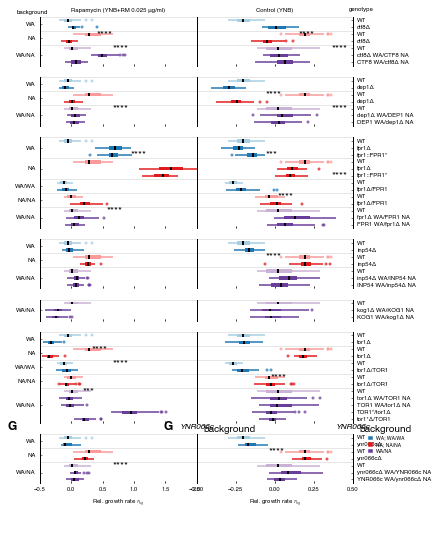

In [491]:
param = 'growth_rate'

color = brewer2mpl.get_map('Paired', 'qualitative', 12).mpl_colors

# background attributes
position_background = {'WA':0, 'NA':1, 'WA/WA':2, 'NA/NA':3, 'WA/NA':4}
color_background_wt = {'WA':color[0], 'NA':color[4], 'WA/WA':color[0], 'NA/NA':color[4], 'WA/NA':color[8]}
color_background_mut = {'WA':color[1], 'NA':color[5], 'WA/WA':color[1], 'NA/NA':color[5], 'WA/NA':color[9]}

# genotype attributes
position_genotype = {
'HU': {u'RNR2':{u'WT':0, u'rnr2Δ':1, u'rnr2Δ/RNR2':2, u'rnr2::RNR2*':3,
                u'rnr2Δ WA/RNR2 NA':4, u'RNR2 WA/rnr2Δ NA':5,
                u'RNR2*/rnr2Δ':6, u'rnr2*Δ/RNR2':7}, 
       u'RNR4':{u'WT':0, u'rnr4Δ':1, u'rnr4Δ/RNR4':2,
                u'rnr4Δ WA/RNR4 NA':3, u'RNR4 WA/rnr4Δ NA':4, u'rnr4::RNR4*':5}},
'RM': {u'CTF8':{u'WT':0, u'ctf8Δ':1,
                u'ctf8Δ WA/CTF8 NA':2, u'CTF8 WA/ctf8Δ NA':3}, 
       u'DEP1':{u'WT':0, u'dep1Δ':1,
                u'dep1Δ WA/DEP1 NA':2, u'DEP1 WA/dep1Δ NA':3},
       u'FPR1':{u'WT':0, u'fpr1Δ':1, u'fpr1Δ/FPR1':2,
                u'fpr1Δ WA/FPR1 NA':3, u'FPR1 WA/fpr1Δ NA':4, u'fpr1::FPR1*':5},
       u'INP54':{u'WT':0, u'inp54Δ':1,
                 u'inp54Δ WA/INP54 NA':2, u'INP54 WA/inp54Δ NA':3}, 
       u'KOG1':{u'WT':0, u'kog1Δ WA/KOG1 NA':1, u'KOG1 WA/kog1Δ NA':2},
       u'TOR1':{u'WT':0, u'tor1Δ':1, u'tor1Δ/TOR1':2, 
                u'tor1Δ WA/TOR1 NA':3, u'TOR1 WA/tor1Δ NA':4, 
                u'TOR1*/tor1Δ':5, u'tor1*Δ/TOR1':6},
       u'YNR066c':{u'WT':0, u'ynr066cΔ':1,
                   u'ynr066cΔ WA/YNR066c NA':2, u'YNR066c WA/ynr066cΔ NA':3}}
}

shape = pd.DataFrame({k: 
 pd.pivot_table(x, values='growth_rate', columns=['population','genotype_long']).shape
 for k,x in pheno_df.groupby(['env_evo','env_test','gene'])
})

for (ii, ((env_evo), gph1)) in enumerate(pheno_df[pheno_df.env_evo=='RM'].groupby(['env_evo'])):

    # remove NaNs
    gph1 = gph1[np.isfinite(gph1[param])]
    
    # calculate axes limits
    (xmin, xmax, ymin, ymax) = range(0, 4)    
    xmin = gph1.groupby('env_test')[param].min()
    xmax = gph1.groupby('env_test')[param].max()
    
    nrows=len(gph1.groupby(['population','genotype_long']))
    ncols=len(gph1.groupby(['env_test']))
        
    height, width = np.array([nrows*0.2, ncols*2.5], dtype=float)
    
    fig = plt.figure(figsize=(width, height), dpi=300)

    grid = gridspec.GridSpec(1, 2, hspace=0.3, wspace=0.)
    
    gs = {}
        
    for (jj, ((env_test), gph2)) in enumerate(gph1.groupby(['env_test'])):
        
#         fig, axes = plt.subplots(1, 2, figsize=(width, height), dpi=300, sharey=True)
        
#         fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,wspace=0)
        
        nrows = len(gph2['gene'].unique())
        ncols = 1
        height_ratios = shape[env_evo,env_test].values.squeeze()
        gs[env_test] = gridspec.GridSpecFromSubplotSpec(nrows, ncols, height_ratios=height_ratios, 
                                                        subplot_spec=grid[0,jj], hspace=0.2, wspace=0.)
    
        axes = {}
        
        for (kk, ((gene), gph3)) in enumerate(gph2.groupby('gene')):
                        
            gph3.loc[:,'rank_background'] = gph3['population'].map(position_background)
            gph3.loc[:,'rank_genotype'] = gph3['genotype_long'].map(position_genotype[env_evo][gene])
            gph3.sort_values(['rank_background','rank_genotype'], 
                             ascending=[False,False], inplace=True)
            
#             ax1 = plt.subplot(gs[env_test][kk])#axes[kk]
            
            if kk == 0:
                axes[env_test] = plt.subplot(gs[env_test][kk])
                ax1 = axes[env_test]
                # set title
                ax1.set_title(environments[env_test], fontsize=6)
            else:
                ax1 = plt.subplot(gs[env_test][kk], sharex=axes[env_test])
            
            gph3 = gph3.set_index(['population','genotype_long'], append=True)[param]\
            .unstack(['population','genotype_long'])
            
            # boxplot
            bp = gph3.plot(ax=ax1, kind='box',vert=False, return_type='dict',
                           labels=gph3.columns.get_level_values('population'))
            
            colors = [color_background_wt[b] if g=='WT' else color_background_mut[b] \
                      for b,g in zip(gph3.columns.get_level_values('population'),gph3.columns.get_level_values('genotype_long'))]
            plot.boxplot_custom(bp, ax1,
                                colors=colors,
                                hatches=['']*30)
            
            for ll, x in enumerate(gph3.columns):
                
                if x in tests[gene]:
                    
                    wt_data = gph3[tests[gene][x]].dropna()
                    mut_data = gph3[x].dropna()
                    z_stat, p_val = stats.ranksums(wt_data,mut_data)
                                        
                    if p_val < 0.001:
                    
                        x_min = min(wt_data.min(),mut_data.min())
                        x_max = max(wt_data.max(),mut_data.max())
                                                        
                        ax1.annotate("", xy=(x_max, ll+0.1), xycoords='data',
                                     arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                                                     connectionstyle="bar,fraction=-0.3"))
                        ax1.annotate(utils.stars(p_val), xy=(x_min+abs(x_max - x_min), ll), xycoords='data',
                                     ha='left', va='center')
            
            # reset ticks
            ax1.set_yticks([])
            ax1.set_yticklabels([])

            ## background
            ystart, yend, ylabels = plot.set_custom_labels(gph3.columns, 0)
            
            # grid
            ygrid=[yst+1.5 for yst in list(set(ystart.values()))]
            [ax1.axhline(g, lw=1, ls="-", color="0.9") for g in ygrid]
            
            # labels
            if jj==0:
                if kk==0:
                    # axis label
                    ax1.set_ylabel('background', transform=ax1.transAxes, fontsize=10, rotation=0)
                    ax1.yaxis.set_label_coords(-0.05, 1.05)
                # tick labels
                ax1.set_yticks([y+1 for y in ylabels.values()], minor=True)
                ax1.set_yticklabels(ylabels.keys(), minor=True, fontsize=8)
                ax1.get_yaxis().tick_left()

            ## genotype
            # labels
            if jj==1:
                if kk==0:
                    # axis label
                    ax1.set_ylabel('genotype', transform=ax2.transAxes, fontsize=10, rotation=0)
                    ax1.yaxis.set_label_coords(1.05, 1.1)
                # tick labels
                ylabels = gph3.columns.get_level_values('genotype_long')
                ax1.set_yticks(np.arange(1, len(ylabels)+1), minor=True)
                ax1.set_yticklabels(['/'.join(y) if isinstance(y, tuple) else y for y in ylabels], minor=True)
                ax1.get_yaxis().tick_right()
                
            
            # set axes labels
            ax1.set_xlabel(r'Rel. growth rate $r_{bg}$', fontsize=10)           
                

# # #         ax.tick_params(axis='x', which='minor', size=0, pad=-6)
# # #         ax.tick_params(axis='x', which='major', size=0, pad=3)

#         if env_test!='YNB':
        ax1.annotate(chr(kk + ord('A')), 
                         xy=(-0.15, 1.15), xycoords=("axes fraction", "axes fraction"),
                         ha='right', va='center', annotation_clip=False, 
                         fontsize=12, fontweight='bold')
        ax1.annotate(gene, 
                         xy=(1., 1.15), xycoords=("axes fraction", "axes fraction"),
                         ha='center', va='center', annotation_clip=False, 
                         fontsize=8, fontstyle='italic')
#             ax1.get_yaxis().tick_left()
#         if jj==1:
#             ax1.get_yaxis().tick_right()
            
        if env_evo=='HU':
            if env_test=='HU':
                ax1.set_xlim(-0.6,0.6)
            elif env_test=='YNB':
                ax1.set_xlim(-0.5,0.5)
            ax1.xaxis.set_major_locator( MaxNLocator(nbins = 4) )
            ax1.xaxis.set_minor_locator( MaxNLocator(nbins = 4) )
        elif env_evo=='RM':
            if env_test=='RM':
                ax1.set_xlim(-0.5,2.0)
            elif env_test=='YNB':
                ax1.set_xlim(-0.5,0.5)
            ax1.xaxis.set_major_locator( MaxNLocator(nbins = 5) )
            ax1.xaxis.set_minor_locator( MaxNLocator(nbins = 5) )
            
        wa_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['WA'])
        na_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['NA'])
        wana_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['WA/NA'])

        leg1 = ax1.legend([wa_artist,na_artist,wana_artist], 
                          ['WA; WA/WA','NA; NA/NA','WA/NA'], 
                          bbox_to_anchor=(1.03, 0.9), ncol=1, 
                          frameon=False, loc='center left',
                          borderaxespad=0, handlelength=0.75, 
                          prop={'size':5}, title='background', 
                          labelspacing=.32)

        # tweak axes
        for ax in fig.get_axes():
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.get_xaxis().tick_bottom()
            
#             if ax.is_first_col():
#                 ax.get_yaxis().tick_left()
# #                 ax.tick_params(axis='y', which='major', labelsize=5)
#             if ax.is_last_col():
#                 ax.get_yaxis().tick_right()
# #                 ax.tick_params(axis='y', which='minor', labelsize=5)

        # axes limits
#         for ax in fig.get_axes():
#         ax.get_yaxis().set_label_coords(-0.05,0.5)
            ax.xaxis.label.set_size(6)
            ax.yaxis.label.set_size(6)
            ax.tick_params(axis='both', which='major', size=2, labelsize=6)
            ax.tick_params(axis='both', which='minor', size=2, labelsize=6)
            for sp in ax.spines.values():
                sp.set(color='k', linewidth=1., linestyle='-')

    fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s.png' % env_evo, 
                dpi=300, bbox_inches='tight')
    fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s.svg' % env_evo, 
                dpi=300, bbox_inches='tight')
plt.show()

In [10]:
color = brewer2mpl.get_map('Paired', 'qualitative', 12).mpl_colors

# background attributes
position_background = {'WA':0, 'NA':1, 'WA/WA':2, 'NA/NA':3, 'WA/NA':4}
color_background_wt = {'WA':color[0], 'NA':color[4], 'WA/WA':color[0], 'NA/NA':color[4], 'WA/NA':color[8]}
color_background_mut = {'WA':color[1], 'NA':color[5], 'WA/WA':color[1], 'NA/NA':color[5], 'WA/NA':color[9]}

# genotype attributes
position_genotype = {
'HU': {u'RNR2':{u'WT':0, u'rnr2Δ':1, u'rnr2Δ/RNR2':2, u'rnr2::RNR2*':3,
                u'rnr2Δ WA/RNR2 NA':4, u'RNR2 WA/rnr2Δ NA':5,
                u'RNR2*/rnr2Δ':6, u'rnr2*Δ/RNR2':7}, 
       u'RNR4':{u'WT':0, u'rnr4Δ':1, u'rnr4Δ/RNR4':2,
                u'rnr4Δ WA/RNR4 NA':3, u'RNR4 WA/rnr4Δ NA':4, u'rnr4::RNR4*':5}},
'RM': {u'CTF8':{u'WT':0, u'ctf8Δ':1,
                u'ctf8Δ WA/CTF8 NA':2, u'CTF8 WA/ctf8Δ NA':3}, 
       u'DEP1':{u'WT':0, u'dep1Δ':1,
                u'dep1Δ WA/DEP1 NA':2, u'DEP1 WA/dep1Δ NA':3},
       u'FPR1':{u'WT':0, u'fpr1Δ':1, u'fpr1Δ/FPR1':2,
                u'fpr1Δ WA/FPR1 NA':3, u'FPR1 WA/fpr1Δ NA':4, u'fpr1::FPR1*':5},
       u'INP54':{u'WT':0, u'inp54Δ':1,
                 u'inp54Δ WA/INP54 NA':2, u'INP54 WA/inp54Δ NA':3}, 
       u'KOG1':{u'WT':0, u'kog1Δ WA/KOG1 NA':1, u'KOG1 WA/kog1Δ NA':2},
       u'TOR1':{u'WT':0, u'tor1Δ':1, u'tor1Δ/TOR1':2, 
                u'tor1Δ WA/TOR1 NA':3, u'TOR1 WA/tor1Δ NA':4, 
                u'TOR1*/tor1Δ':5, u'tor1*Δ/TOR1':6},
       u'YNR066c':{u'WT':0, u'ynr066cΔ':1,
                   u'ynr066cΔ WA/YNR066c NA':2, u'YNR066c WA/ynr066cΔ NA':3}}
}

2 0
2 1


/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


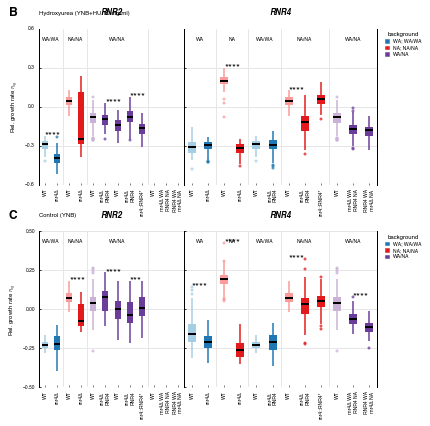

In [465]:
param = 'growth_rate'

# Annotate gene groups
pheno_df.loc[pheno_df['gene'].isin(['RNR2','RNR4']),'gene_group'] = 1
pheno_df.loc[pheno_df['gene'].isin(['CTF8','FPR1','TOR1']),'gene_group'] = 1
pheno_df.loc[pheno_df['gene'].isin(['DEP1','INP54','KOG1','YNR066c']),'gene_group'] = 2

shape = pd.DataFrame({k: 
 pd.pivot_table(x, values='growth_rate', columns=['population','genotype_long']).shape
 for k,x in pheno_df.groupby(['env_evo','env_test','gene_group','gene'])
})

for (ii, ((env_evo), gph1)) in enumerate(pheno_df[pheno_df.env_evo=='HU'].groupby(['env_evo'])):#[pheno_df.env_evo=='HU']

    # remove NaNs
    gph1 = gph1[np.isfinite(gph1[param])]
    


    
    for (mm, ((gene_group), gph2)) in enumerate(gph1.groupby('gene_group')):
        
        
        # calculate axes limits
        (xmin, xmax, ymin, ymax) = range(0, 4)    
        xmin = gph2.groupby('env_test')[param].min()
        xmax = gph2.groupby('env_test')[param].max()
    
        nrows=len(gph2['env_test'].unique())*len(gph2['gene_group'].unique())
        ncols=len(gph2.groupby(['population','genotype_long']))
        
        height, width = np.array([3*nrows, 0.3*ncols], dtype=float)#[0.3075*nrows, 2.5*ncols]

        fig = plt.figure(figsize=(width, height), dpi=300)

        import matplotlib.gridspec as gridspec
        grid = gridspec.GridSpec(nrows, 1, hspace=0.3)
    
        gs = {}
    
        idx = 0

        for (jj, ((env_test), gph3)) in enumerate(gph2.groupby('env_test')):
        
            
            nrows = 1#len(gph2['gene_group'].unique())
            ncols = len(gph3['gene'].unique())#*len(gph3['gene_group'].unique())
            print ncols, idx
            width_ratios = shape[env_evo,env_test,gene_group].values.squeeze()
            gs[(env_test,gene_group)] = gridspec.GridSpecFromSubplotSpec(nrows, ncols, width_ratios=width_ratios, 
                                                                         subplot_spec=grid[idx], hspace=0.3, wspace=0)
            idx += 1
                
            axes = {}       

            for (kk, ((gene), gph4)) in enumerate(gph3.groupby('gene')):                
#                 axes[(env_test,gene_group)] = plt.subplot(gs[(env_test,gene_group)][0,kk])
#                 ax1 = axes[(env_test,gene_group)]
            
                if kk==0:
                    axes[(env_test,gene_group)] = plt.subplot(gs[(env_test,gene_group)][0,kk])
                    ax1 = axes[(env_test,gene_group)]
                    ax1.annotate(chr(idx + ord('A')), 
                             xy=(-0.15, 1.1), xycoords=("axes fraction", "axes fraction"),
                             ha='right', va='center', annotation_clip=False, 
                             fontsize=12, fontweight='bold')  
                else:
                    ax1 = plt.subplot(gs[(env_test,gene_group)][0,kk], sharex=axes[(env_test,gene_group)])
            
                if ax1.is_first_col():
                    ax1.annotate(environments[env_test], 
                             xy=(0., 1.1), xycoords=("axes fraction", "axes fraction"),
                             ha='left', va='center', annotation_clip=False, 
                             fontsize=6)  
            
                gph4.loc[:,'rank_background'] = gph4['population'].map(position_background)
                gph4.loc[:,'rank_genotype'] = gph4['genotype_long'].map(position_genotype[env_evo][gene])
                gph4.sort_values(['rank_background','rank_genotype'], 
                             ascending=[True,True], inplace=True)
            
                gph4 = gph4.set_index(['population','genotype_long'], append=True)[param]\
                .unstack(['population','genotype_long'])
            
                # boxplot
                bp = gph4.plot(ax=ax1, kind='box', vert=True, return_type='dict',
                               labels=gph4.columns.get_level_values('population'))
        
                colors = [color_background_wt[b] if g=='WT' else color_background_mut[b] \
                          for b,g in zip(gph4.columns.get_level_values('population'),gph4.columns.get_level_values('genotype_long'))]
                plot.boxplot_custom(bp, ax1, colors=colors, hatches=['']*30)
            
                for ll, x in enumerate(gph4.columns):
                
                    if x in tests[gene]:
                    
                        wt_data = gph4[tests[gene][x]].dropna()
                        mut_data = gph4[x].dropna()
                        z_stat, p_val = stats.ranksums(wt_data,mut_data)
                                        
                        if p_val < 0.001:
                    
                            y_min = min(wt_data.min(),mut_data.min())
                            y_max = max(wt_data.max(),mut_data.max())
                                                        
                            ax1.annotate("", xy=(ll+0.1, y_max), xycoords='data',
                                         arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                                                         connectionstyle="bar,fraction=-0.3"))
                            ax1.text(ll, y_min+abs(y_max - y_min),
                                     utils.stars(p_val),
                                     ha='left', va='center')

#             x0, y0 = m(x[-1], y[-1])
#             x1, y1 = m(x[-1] + 0.5, y[-1] + 0.5)
#             x0,x1,y0,y1 = 0.1,0.5,0.1,0.5
#             if gene=='RNR2':
#                 im = ax1.imshow(plt.imread(dir_supp+'figures/figureSX_pheno_constructs/FPR1.png'), 
#                                 extent=(x0, x1, y0, y1))
            
#             stars=stattest[(stattest.p_val<1e-3)&(stattest.env_evo==env_evo)&\
#                        (stattest.env_test==env_test)&(stattest.mut==(background,genotype))]
#             if len(stars)>0:
#                 y_min=idx
#                 y_max=idx+1
#                 x_min=stars['min']
#                 x_max=stars['max']
#                 ax1.annotate("", xy=(x_max+0.1, y_min), xycoords='data',
#                          arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                                          connectionstyle="bar,fraction=-0.3"))
#                 ax1.text(x_max+0.15, y_min+abs(y_max - y_min)*0.3, 
#                      stars['stars'].values[0],
#                      ha='left', va='center')
            
                # set title
                ax1.set_title(gene, fontsize=8, fontstyle='italic', fontweight='bold', 
                              ha='center', va='top', y=1.1)
                if kk==0:
                    # set axes labels
                    ax1.set_ylabel(r'Rel. growth rate $r_{bg}$', fontsize=10)
                else:
                    ax1.set_yticks([])
                    ax1.set_yticklabels([])
#                 # reset ticks
#                 for ax in [ax1]:
#                     ax.set_xticks([])
#                     ax.set_xticklabels([])

                ## background
                xstart, xend, xlabels = plot.set_custom_labels(gph4.columns, 0)

                # labels
    #             ax1.set_xticks([x+1 for x in xlabels.values()], minor=False)
    #             ax1.set_xticklabels(xlabels.keys(), minor=False, fontsize=6)
                for k, v in xlabels.iteritems():
                    ax1.annotate(k, xy=(v+1, 0.95), xycoords=("data", "axes fraction"),
                                 ha='center', va='top', annotation_clip=False, fontsize=5)
            
                # grid
                xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
                [ax1.axvline(g, lw=1, ls="-", color="0.9") for g in xgrid]
    
#             ax1.get_xaxis().tick_top()
        
#             if ax1.is_last_col():
#                 ax1.annotate('background', xy=(1.025, 0.9), xycoords='axes fraction', fontsize=6)
#                 ax1.annotate('genotype', xy=(1.025, -0.1), xycoords='axes fraction', fontsize=6)
#                              arrowprops=dict(arrowstyle="-", ec='#aaaaaa', 
#                                              connectionstyle="bar,fraction=-0.3"))

#                 ax1.set_xlabel('background', transform=ax1.transAxes, fontsize=10, rotation=0)
#                 ax1.xaxis.set_label_coords(-0.05, 1.1)
#                 ax1.set_xlabel('genotype', transform=ax1.transAxes, fontsize=10, rotation=0)
#                 ax1.xaxis.set_label_coords(-0.05, -.1)

                ## genotype
            
                # labels
                xlabels = gph4.columns.get_level_values('genotype_long')
    #             ax1.set_xticks([])
    #             ax1.set_xticklabels([])
                ax1.set_xticks([x+1 for x in np.arange(len(xlabels))], minor=False)
                ax1.set_xticklabels([x.replace('/','\n') if isinstance(x, tuple) else x.replace('/','\n') for x in xlabels], 
                                    minor=False, rotation=90)

#             xstart, xend, xlabels = plot.set_custom_labels(gph3.columns, 1)
            
#             # labels
#             ax2.set_xticks([x+1 for x in xlabels.values()], minor=False)
#             ax2.set_xticklabels(xlabels.keys(), minor=False, fontsize=6)
            
#             ax1.get_xaxis().tick_bottom()
        
#             ax1.set_xticks(np.linspace(1, ax1.get_xbound()[1], 5))
#             ax2.set_xticks(np.linspace(1, ax2.get_xbound()[1], 5))

                
                ax1.tick_params(axis='x', which='major', size=2, labelsize=5)#, pad=-10)
#             ax2.tick_params(axis='x', which='major', size=0, labelsize=4.5, pad=5)
                ax1.tick_params(axis='y', which='major', size=2, labelsize=5)
#             ax2.tick_params(axis='y', which='major', size=1, labelsize=4)
            
                if env_evo=='HU':
                    if env_test=='HU':
                        ax1.set_ylim(-0.6,0.6)
                        ax1.yaxis.set_major_locator( MaxNLocator(nbins = 4) )
                        ax1.yaxis.set_minor_locator( MaxNLocator(nbins = 4) )
                    elif env_test=='YNB':
                        ax1.set_ylim(-0.5,0.5)
                        ax1.yaxis.set_major_locator( MaxNLocator(nbins = 4) )
                        ax1.yaxis.set_minor_locator( MaxNLocator(nbins = 4) )
                elif env_evo=='RM':
                    if env_test=='RM':
                        ax.set_ylim(-0.5,2.0)
                    elif env_test=='YNB':
                        ax.set_ylim(-0.5,0.5)
                    ax.yaxis.set_major_locator( MaxNLocator(nbins = 5) )
                    ax.yaxis.set_minor_locator( MaxNLocator(nbins = 5) )

                # tweak axes
                for ax in fig.get_axes():
                    ax.spines['top'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.spines['right'].set_visible(True)
                    ax.spines['left'].set_visible(True)
                                
                    ax.xaxis.label.set_size(6)
                    ax.yaxis.label.set_size(6)

                    for sp in ax.spines.values():
                        sp.set(color='k', linewidth=1, linestyle='-')
    
            wa_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['WA'])
            na_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['NA'])
            wana_artist = patches.Rectangle((0,0), width=1, height=1, color=color_background_mut['WA/NA'])

            leg1 = ax1.legend([wa_artist,na_artist,wana_artist], 
                             ['WA; WA/WA','NA; NA/NA','WA/NA'], 
                             bbox_to_anchor=(1.03, 0.9), ncol=1, 
                             frameon=False, loc='center left',
                             borderaxespad=0, handlelength=0.75, 
                             prop={'size':5}, title='background', 
                             labelspacing=.32)
        
            wt_artist = patches.Rectangle((0,0), width=1, height=1, color='k')
            construct_artist = patches.Rectangle((0,0), width=1, height=1, color='0.9')

#         leg2 = ax1.legend([wt_artist,construct_artist], 
#                           ['WT','construct'], 
#                           bbox_to_anchor=(1.05, 0.1), ncol=1, 
#                           frameon=False, loc='center left',
#                           borderaxespad=0, handlelength=0.75, 
#                           prop={'size':5}, title='genotype', 
#                           labelspacing=.32)
        
            for leg in [leg1,leg2]:
                plt.setp(leg.get_title(),fontsize=6)
            
#         ax1.add_artist(leg1)
#         ax1.add_artist(leg2)
    
        fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s_%s.png' % (env_evo,gene_group), 
                dpi=300, bbox_inches='tight')
        fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s_%s.svg' % (env_evo,gene_group), 
                dpi=300, bbox_inches='tight')
plt.show()

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


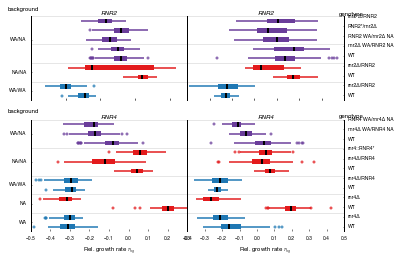

In [132]:
param = 'growth_rate'

shape = pd.DataFrame({k: 
 pd.pivot_table(x, values='growth_rate', columns=['population','genotype_long']).shape
 for k,x in pheno_df.groupby(['env_evo','env_test','gene'])
})

for (ii, ((env_evo), gph1)) in enumerate(pheno_df[pheno_df.env_evo=='HU'].groupby(['env_evo'])):#[pheno_df.env_evo=='HU']

    # remove NaNs
    gph1 = gph1[np.isfinite(gph1[param])]
    
    # calculate axes limits
    (xmin, xmax, ymin, ymax) = range(0, 4)    
    xmin = gph1.groupby('env_test')[param].min()
    xmax = gph1.groupby('env_test')[param].max()
    
    ncols=len(gph1.groupby(['env_test']))
    nrows=len(gph1.groupby(['population','genotype_long']))
        
    height, width = np.array([0.2*nrows, 2.5*ncols], dtype=float)#[0.3075*nrows, 2.5*ncols]

    fig = plt.figure(figsize=(width, height), dpi=300)

    grid = gridspec.GridSpec(1, 2, hspace=0.4, wspace=0)

    gs = {}
    
    for (jj, ((env_test), gph2)) in enumerate(gph1.groupby('env_test')):
        
        nrows = len(gph2['gene'].unique())
        ncols = 1
        height_ratios = shape[env_evo,env_test].values.squeeze()
        gs[env_test] = gridspec.GridSpecFromSubplotSpec(nrows, ncols, height_ratios=height_ratios, 
                                                        subplot_spec=grid[0,jj], wspace=0)
                
        axes = {}
        
        for (kk, ((gene), gph3)) in enumerate(gph2.groupby('gene')):
            
            axes[env_test] = plt.subplot(gs[env_test][kk])
            
            ax1 = axes[env_test]
            ax2 = ax1.twinx()
            
#             if jj==0:
#                 ax1.get_yaxis().tick_left()
#             elif jj==1:
#                 ax1.get_yaxis().tick_right()
#             ax2.get_yaxis().tick_right()

            gph3.loc[:,'rank_background'] = gph3['population'].map(position_background)
            gph3.loc[:,'rank_genotype'] = gph3['genotype_long'].map(position_genotype[env_evo][gene])
            gph3.sort_values(['rank_background','rank_genotype'], 
                             ascending=[True,True], inplace=True)
            
            gph3 = gph3.set_index(['population','genotype_long'], append=True)[param]\
            .unstack(['population','genotype_long'])
            
            # boxplot
            bp = gph3.plot(ax=ax1, kind='box', vert=False, return_type='dict',
                           labels=gph3.columns.get_level_values('population'))
        
            colors = [color_background_mut[b] for b in gph3.columns.get_level_values('population')]
            plot.boxplot_custom(bp, ax1, colors=colors, hatches=['']*30)
            
            # set title
            ax1.set_title(gene, fontsize=6, style='italic', ha='center', va='top')
            # set axes labels
            ax1.set_xlabel(r'Rel. growth rate $r_{bg}$', fontsize=10)
                
            # reset ticks
            for ax in [ax1,ax2]:
                ax.set_yticks([])
                ax.set_yticklabels([])
                
            ## background
            ystart, yend, ylabels = plot.set_custom_labels(gph3.columns, 0)

            if jj==0:
                ax1.get_yaxis().tick_left()
                ax1.set_ylabel('background', transform=ax1.transAxes, fontsize=10, rotation=0)
                ax1.yaxis.set_label_coords(-0.05, 1.05)
                # labels
                ax1.set_yticks([y+1 for y in ylabels.values()], minor=True)
                ax1.set_yticklabels(ylabels.keys(), minor=True, fontsize=8)
                
            # grid
            xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
            [ax1.axhline(g, lw=1, ls="-", color="0.9") for g in xgrid]

            ## genotype
            if jj==1:
                ax2.get_yaxis().tick_right()
                ax2.set_ylabel('genotype', transform=ax2.transAxes, fontsize=10, rotation=0)
                ax2.yaxis.set_label_coords(1.05, 1.05)
                # labels
                ylabels = gph3.columns.get_level_values('genotype_long')
                ax2.set_yticks([])
                ax2.set_yticklabels([])
                ax2.set_yticks([y+.5 for y in np.arange(len(ylabels))], minor=True)
                ax2.set_yticklabels(['/'.join(y) if isinstance(y, tuple) else y for y in ylabels], minor=True)                
            else:
                ax2.set_yticks([])
                ax2.set_yticklabels([])
                
#             plot.align_yaxis(ax1, 0.5, ax2, 0.5)
            
#             ax1.tick_params(axis='x', which='major', size=0, labelsize=5, pad=-10)
#             ax1.tick_params(axis='y', which='major', size=2, labelsize=6)
#             ax2.tick_params(axis='x', which='major', size=0, labelsize=5, pad=-10)
#             ax2.tick_params(axis='y', which='major', size=2, labelsize=6)
            
            # tweak axes
            for ax in fig.get_axes():
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['right'].set_visible(True)
                ax.spines['left'].set_visible(True)
                                
                ax.xaxis.label.set_size(6)
                ax.yaxis.label.set_size(6)
                
                ax.tick_params(axis='both', which='major', size=2, labelsize=5)
                ax.tick_params(axis='both', which='minor', size=1, labelsize=5)

                for sp in ax.spines.values():
                    sp.set(color='k', linewidth=1, linestyle='-')

    fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s.png' % env_evo, 
                dpi=300, bbox_inches='tight')
    fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s.svg' % env_evo, 
                dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#             # labels
#             ax1.set_yticks([x+1 for x in xlabels.values()], minor=False)
#             ax1.set_yticklabels(xlabels.keys(), minor=False, fontsize=6)
# #             for k, v in xlabels.iteritems():
# #                 ax1.annotate(k, xy=(v+1, 0.95), xycoords=("data", "axes fraction"),
# #                              ha='center', va='top', annotation_clip=False, fontsize=5)
            
#             # grid
#             xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
#             [ax1.axhline(g, lw=1, ls="-", color="0.9") for g in xgrid]

# #             if ax1.is_last_col():
# #                 ax1.annotate('background', xy=(1.025, 0.9), xycoords='axes fraction', fontsize=6)
# #                 ax1.annotate('genotype', xy=(1.025, -0.1), xycoords='axes fraction', fontsize=6)
                
#             ## genotype
            
#             # labels
#             if ax2.is_last_col():
#                 xlabels = gph3.columns.get_level_values('genotype_long')
#                 ax2.set_yticks([x+1 for x in np.arange(len(xlabels))], minor=False)
#                 ax2.set_yticklabels([x.replace('/','\n') if isinstance(x, tuple) else x.replace('/','\n') for x in xlabels], 
#                                     minor=False, fontsize=8)
#             else:
#                 ax2.set_yticks([])
#                 ax2.set_yticklabels([])

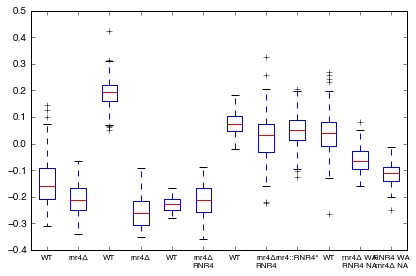

In [25]:
fig, ax = plt.subplots(1,1)

gph3.plot(ax=ax, kind='box', vert=True, labels=gph3.columns.get_level_values('population'))

xlabels = gph3.columns.get_level_values('genotype_long')
ax.set_xticks([x+1 for x in np.arange(len(xlabels))], minor=False)
ax.set_xticklabels([x.replace('/','\n') if isinstance(x, tuple) else x.replace('/','\n') for x in xlabels], minor=False, fontsize=8)

In [ ]:
gph3.columns.get_level_values('genotype_long')

In [ ]:
plot.set_custom_labels(gph3.columns, 1)

In [ ]:
xlabels = gph3.columns.get_level_values('genotype_long')
np.arange(len(xlabels))

In [ ]:
im = plt.imshow(plt.imread(dir_supp+'figures/figureSX_pheno_constructs/FPR1.png'), extent=(x0, x1, y0, y1))
xlabels

In [ ]:
from mpl_toolkits.basemap import Basemap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox